In [1]:
# %reload_ext autoreload
# %autoreload 2

import os
import sys
sys.path.insert(0, '..')

import torch
import numpy as np

from datasets.get import get_dataloader
import metrics.metrics as m
from models.get import get_model

import matplotlib.pyplot as plt

In [2]:
root_data_path = '/data/Datasets/Charades/Charades_v1_480'
map_file = '/data/Datasets/Charades/Annotations/Charades_v1_test.csv'
pretrained_weights = '/data/OnlineActionRecognition/models/charades_resnet50nl32_mAP32/charades_resnet50nl32_config5_reducelr_full.pth'
sample_frames = 32
dataset = 'charades'
backbone = 'resnet50'
arch = 'nonlocal_net'
mode = 'test'

In [3]:
# Loading data
data_loader = get_dataloader(dataset, map_file, root_data_path, 1, mode=mode,
                             sample_frames=sample_frames, num_workers=4,
                             distributed=False)
total_num = len(data_loader.dataset)
num_classes = data_loader.dataset.num_classes
data_gen = enumerate(data_loader)

In [4]:
# Loading model
model = get_model(arch=arch, backbone=backbone, pretrained_weights=pretrained_weights,
                  mode=mode, num_classes=num_classes, non_local=True,
                  frame_num=sample_frames, log_name='eval')
model.eval()

video_metric = m.Video_mAP(m.mAP()) if data_loader.dataset.multi_label else m.Video_Accuracy(m.TopK(k=(1, 5)))

In [5]:
%matplotlib notebook

In [6]:
from datasets.video_record import VideoRecord
def get_item(dataset, index):
    label, video_path = dataset.video_list[index]
    record = VideoRecord(os.path.join(dataset.root_path, video_path), label)
    segment_indices = np.array(dataset._get_test_indices(record)).reshape(-1, dataset.sample_frames)
    return torch.stack([dataset._get_train_target(record, s)['target'] for s in segment_indices])

torch.Size([1, 157])
torch.Size([1, 30, 3, 32, 256, 256])


<IPython.core.display.Javascript object>


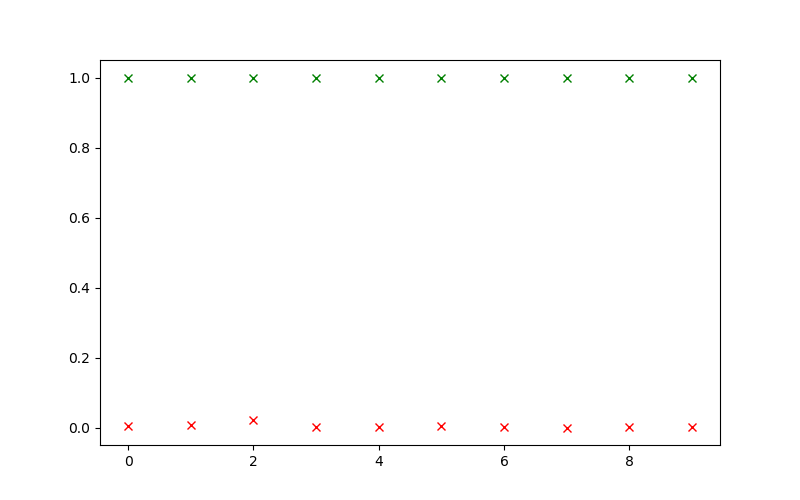

<IPython.core.display.Javascript object>


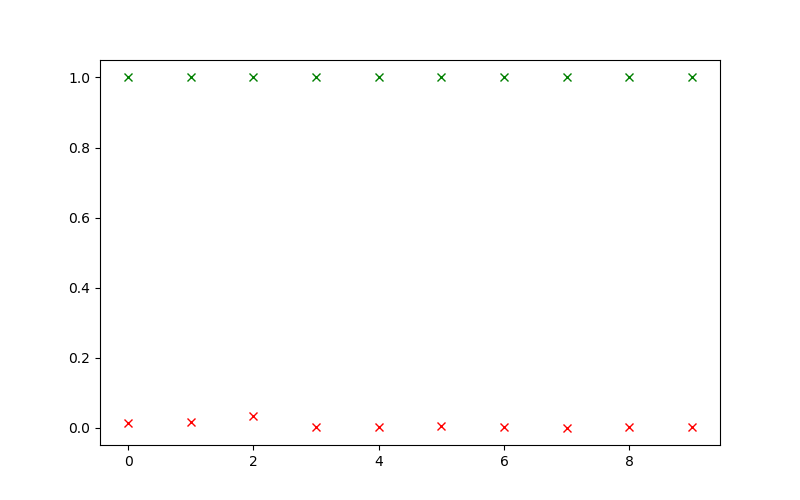

<IPython.core.display.Javascript object>


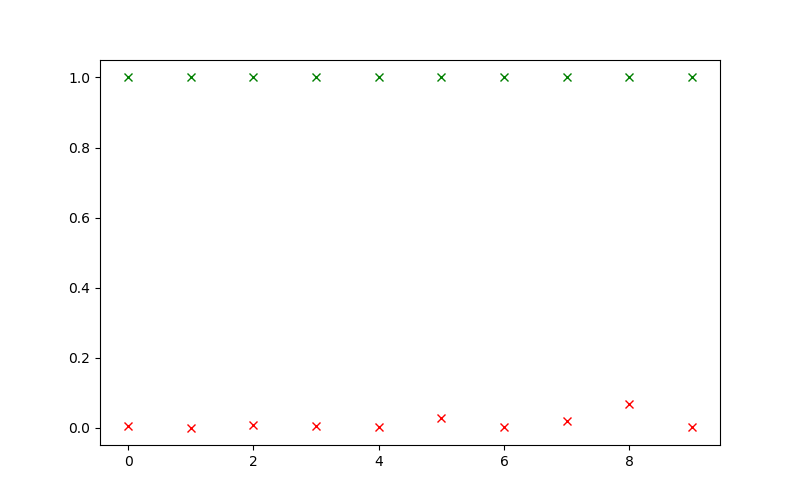

<IPython.core.display.Javascript object>


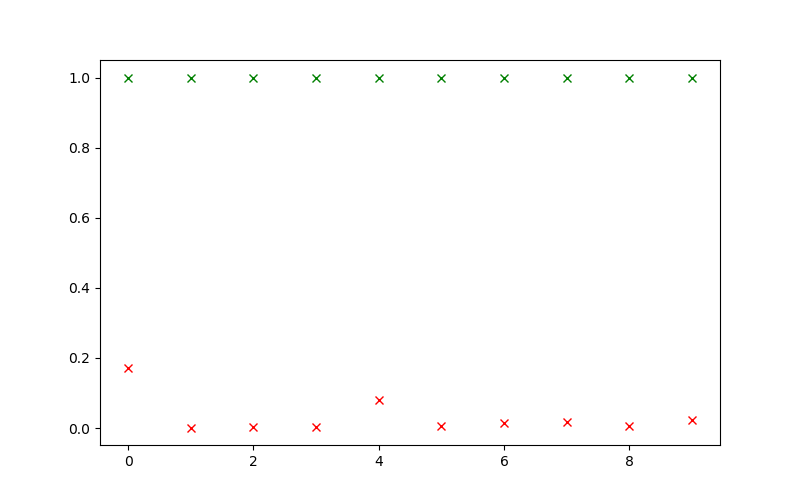

In [10]:
i, (data, label) = next(data_gen)
print(label['target'].shape)
print(data.shape)

data = data.squeeze(0).cuda()
with torch.no_grad():
    output = model(data).cpu()
    
    avg_pool = torch.nn.AvgPool1d(3)
    data = output.view(1, -1, num_classes)
    data = data.permute(0, 2, 1)
    data = avg_pool(data)
    data = data.view(-1, num_classes)
    
    prediction = torch.sigmoid(data).squeeze(0)

gt = get_item(data_loader.dataset, i)

for j in range(157):
    if label['target'][0][j]:
        fig = plt.figure(figsize=(8,5))
        plt.plot(np.arange(10), gt[:, j].numpy(), 'x', color='g')
        plt.plot(np.arange(10), prediction[:, j].detach().numpy(), 'x', color='r')
        plt.show()    
    

In [7]:
prediction.shape

torch.Size([30, 157])

In [30]:
label['target'][0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], dtype=torch.int32)

In [31]:
data_loader.dataset[i][1]

{'target': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], dtype=torch.int32),
 'video_path': 'YN3AA'}

In [32]:
gt[:, -4]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [33]:
gt.sum(axis=0)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  8,  0,  8,  4,  4,  0,  5,  0,  8,  4,  4,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
         0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  3,  0, 10,  0,  0,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  3,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  2,  3,  0,  0,  0,  0,  5])